In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm
import cv2
import random
from scipy.ndimage import rotate
import gc
import datetime
from sklearn.metrics import roc_auc_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using TensorFlow backend.


In [2]:
#trainimg = np.load("../input/siimisic-melanoma-resized-images/x_train_64.npy")
#trainimg.shape

In [3]:
traindata = pd.read_csv("../input/melanoma-merged-external-data-512x512-jpeg/marking.csv")
traindata

,patient_id,image_id,target,source,sex,age_approx,anatom_site_general_challenge
0,IP_7279968,ISIC_2637011,0,ISIC20,male,45.0,head/neck
1,IP_3075186,ISIC_0015719,0,ISIC20,female,45.0,upper extremity
2,IP_2842074,ISIC_0052212,0,ISIC20,female,50.0,lower extremity
3,IP_6890425,ISIC_0068279,0,ISIC20,female,45.0,head/neck
4,IP_8723313,ISIC_0074268,0,ISIC20,female,55.0,upper extremity
...,...,...,...,...,...,...,...
60482,NaN,ISIC_0013518,1,SLATMD,NaN,NaN,NaN
60483,NaN,ISIC_0014688,1,SLATMD,NaN,NaN,NaN
60484,NaN,ISIC_0015256,1,SLATMD,NaN,NaN,NaN
60485,NaN,ISIC_0014809,1,SLATMD,NaN,NaN,NaN


In [4]:
traindata["image"] = None
for i in traindata.index:
    traindata.at[i, "image"] = cv2.resize(cv2.imread("../input/melanoma-merged-external-data-512x512-jpeg/512x512-dataset-melanoma/512x512-dataset-melanoma/%s.jpg" % (traindata.at[i, "image_id"])), (64, 64), interpolation = cv2.INTER_AREA)

In [5]:
traindata

,patient_id,image_id,target,source,sex,age_approx,anatom_site_general_challenge,image
0,IP_7279968,ISIC_2637011,0,ISIC20,male,45.0,head/neck,"[[[166, 122, 128], [180, 128, 142], [181, 132,..."
1,IP_3075186,ISIC_0015719,0,ISIC20,female,45.0,upper extremity,"[[[160, 102, 76], [163, 105, 81], [169, 110, 8..."
2,IP_2842074,ISIC_0052212,0,ISIC20,female,50.0,lower extremity,"[[[195, 132, 150], [199, 134, 152], [201, 131,..."
3,IP_6890425,ISIC_0068279,0,ISIC20,female,45.0,head/neck,"[[[115, 61, 59], [139, 75, 76], [152, 85, 90],..."
4,IP_8723313,ISIC_0074268,0,ISIC20,female,55.0,upper extremity,"[[[178, 125, 111], [181, 126, 115], [187, 133,..."
...,...,...,...,...,...,...,...,...
60482,NaN,ISIC_0013518,1,SLATMD,NaN,NaN,NaN,"[[[61, 68, 87], [67, 73, 91], [102, 92, 102], ..."
60483,NaN,ISIC_0014688,1,SLATMD,NaN,NaN,NaN,"[[[165, 150, 130], [212, 178, 146], [210, 174,..."
60484,NaN,ISIC_0015256,1,SLATMD,NaN,NaN,NaN,"[[[182, 117, 97], [195, 128, 107], [197, 128, ..."
60485,NaN,ISIC_0014809,1,SLATMD,NaN,NaN,NaN,"[[[204, 161, 147], [198, 149, 130], [207, 150,..."


In [6]:
traindata.to_csv("raw_melanoma_data.csv")

In [7]:
traindata.query("target == 1").shape

(5479, 8)

Data aug functions

In [8]:
def rotate_img(img, angle, bg_patch=(10,10)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    else:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img
# 0 = hor, 1 = vert
def distort(img, orientation=0, func=np.sin, x_scale=0.03, y_scale=2):
    #assert orientation[:3] in ['hor', 'ver'], "dist_orient should be 'horizontal'|'vertical'"
    #orientation = orientation % 2
    assert func in [np.sin, np.cos], "supported functions are np.sin and np.cos"
    assert 0.00 <= x_scale <= 0.1, "x_scale should be in [0.0, 0.1]"
    assert 0 <= y_scale <= min(img.shape[0], img.shape[1]), "y_scale should be less then image size"
    img_dist = img.copy()
    
    def shift(x):
        return int(y_scale * func(np.pi * x * x_scale))
    
    for c in range(3):
        for i in range(img.shape[orientation == 1]):
            if orientation == 1:
                img_dist[:, i, c] = np.roll(img[:, i, c], shift(i))
            else:
                img_dist[i, :, c] = np.roll(img[i, :, c], shift(i))
            
    return img_dist
# 0 = right, 1 = left, 2 = down, 3 = up
# "words" are a phantasm actually
def translate(img, shift=5, direction=0, roll=True):
    #assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
    #dimention = dimention % 4
    img = img.copy()
    if direction == 0:
        right_slice = img[:, -shift:].copy()
        img[:, shift:] = img[:, :-shift]
        if roll:
            img[:,:shift] = np.fliplr(right_slice)
    if direction == 1:
        left_slice = img[:, :shift].copy()
        img[:, :-shift] = img[:, shift:]
        if roll:
            img[:, -shift:] = left_slice
    if direction == 2:
        down_slice = img[-shift:, :].copy()
        img[shift:, :] = img[:-shift,:]
        if roll:
            img[:shift, :] = down_slice
    if direction == 3:
        upper_slice = img[:shift, :].copy()
        img[:-shift, :] = img[shift:, :]
        if roll:
            img[-shift:,:] = upper_slice
    return img
# (0, 1, 2) = ('r', 'g', 'b')
#def change_channel_ratio(img, channel=0, ratio=0.5):
    #assert channel in 'rgb', "Value for channel: r|g|b"
#    img = img.copy()
#    ci = channel
#    img[:, :, ci] *= ratio
#    return img

def hair(img):
        n_hairs = random.randint(0, 2)

        if not n_hairs:
            return img

        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir("../input/images/720563_1253590_bundle_archive") if 'png' in im]

        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join("../input/images/720563_1253590_bundle_archive", random.choice(hair_images)))
            b,g,r = cv2.split(hair)           # get b, g, r
            hair = cv2.merge([r,g,b]) # convert to rgb
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10,255,cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)
            
            
            
            dst = cv2.add(img_bg, hair_fg)
            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst

        return img

    
def augs(img, x):
    if x == 0:
        return cv2.flip(img, -1)
    elif x == 1:
        return cv2.flip(img, 0)
    elif x == 2:
        return cv2.flip(img, 1)
    elif x == 3:
        return translate(img, direction = random.randrange(4))
    elif x == 4:
        return distort(img, orientation = random.randrange(2))
    elif x == 5:
        return rotate_img(img, random.randint(20,110))
    elif x == 6:
        return hair(img)

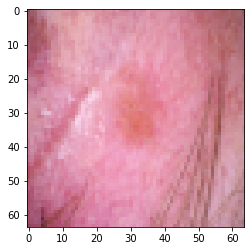

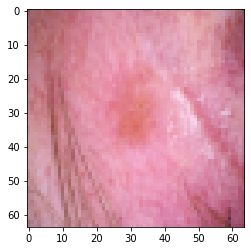

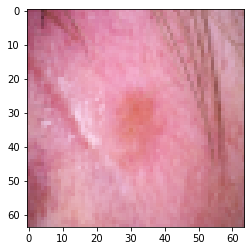

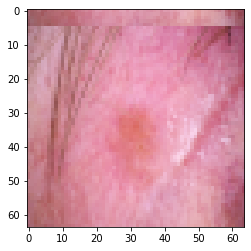

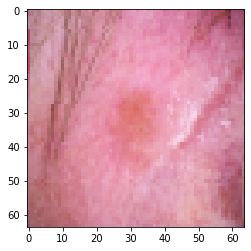

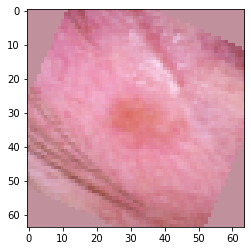

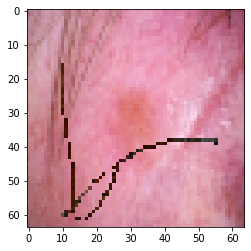

In [9]:
#we try out these distortions
img = traindata.at[0, "image"]
for a in range(7):
    plt.imshow(augs(img, a))
    plt.show()

In [10]:
#mdf -> melanoma dataframe for future me
#mdftrain, mdftest are train and test respectively

mones = traindata["target"]==1
mdf = traindata[mones]
mdftrain = mdf.sample(frac = 0.8)
mdftest = mdf.drop(mdftrain.index)

In [11]:
def augmentdata(df, amp):
    weights = [1, 1, 1, 5, 5, 5, 3] #we don't want that many flips
    def locaug(img):
        return augs(img, random.choices(range(7), weights = weights)[0])
    dfsize = df.shape[0]
    unmodified = range(df.shape[0])
    tmp1 = df.columns.get_loc("image")
    tmp2 = df.columns.get_loc("target")
    dfTmp = df.copy()
    for a in range(int(amp - 1)):
        dfTmp.loc[:, "image"] = dfTmp.loc[:, "image"].map(locaug)
        df = df.append(dfTmp, ignore_index = True)
    if amp != int(amp):
        dfTmp = dfTmp.loc[random.sample(unmodified, int(dfsize * (amp - int(amp))))]
        dfTmp.loc[:, "image"] = dfTmp.loc[:, "image"].map(locaug)
        df = df.append(dfTmp, ignore_index = True)
    return df

In [12]:
mdftrain = augmentdata(mdftrain, 5)
mdftrain = augmentdata(mdftrain, 4)
#mdftest = augmentdata(mdftest, 5)
#mdftest = augmentdata(mdftest, 4)

In [13]:
print(mdftrain.shape)
print(mdftest.shape)

(87660, 8)
(1096, 8)


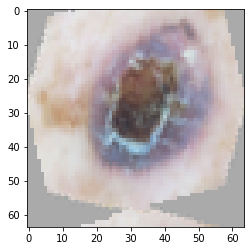

In [14]:
plt.imshow(mdftrain.iat[-30, 7])
plt.show()

In [15]:
#bdf -> benign (duh) dataframe for future me
#bdftrain/test like mdftrain/test
bones = traindata["target"] == 0
benigndf = traindata[bones]
benigndftrain = benigndf.sample(frac = 0.8)
benigndftest = benigndf.drop(benigndftrain.index)

In [16]:
print(benigndftrain.shape)
print(benigndftest.shape)

(44006, 8)
(11002, 8)


In [17]:
benigndftrain = augmentdata(benigndftrain, 2)
benigndftrain = augmentdata(benigndftrain, 1.5)
#bdftest = augmentdata(bdftest, 2)
#bdftest = augmentdata(bdftest, 1.5)

In [18]:
print(benigndftrain.shape)
print(benigndftest.shape)

(132018, 8)
(11002, 8)


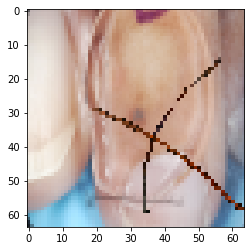

In [19]:
plt.imshow(benigndf.iat[-60, 7])
plt.show()

In [20]:
traindata = mdftrain.append(benigndftrain, ignore_index = True)
testdata = mdftest.append(benigndftest, ignore_index = True)
print(traindata.shape)
print(testdata.shape)

(219678, 8)
(12098, 8)


In [21]:
del mdftrain
del mdftest
del benigndftrain
del benigndftest
gc.collect()

22025

In [22]:
traindata = traindata.sample(frac=1).reset_index(drop=True)
traindata.head()

,patient_id,image_id,target,source,sex,age_approx,anatom_site_general_challenge,image
0,BCN_0000509,ISIC_0069864,1,ISIC19,male,40.0,upper extremity,"[[[109, 107, 111], [109, 107, 111], [109, 107,..."
1,HAM_0000945,ISIC_0031104,0,ISIC19,female,60.0,lower extremity,"[[[245, 163, 177], [247, 178, 194], [247, 184,..."
2,IP_3512888,ISIC_8483490,0,ISIC20,female,35.0,lower extremity,"[[[186, 104, 144], [192, 117, 154], [198, 126,..."
3,NaN,ISIC_0000306,1,ISIC19,male,50.0,upper extremity,"[[[37, 26, 21], [37, 27, 20], [41, 28, 26], [7..."
4,IP_6649505,ISIC_8119644,0,ISIC20,male,80.0,lower extremity,"[[[151, 87, 109], [163, 92, 118], [174, 101, 1..."


In [23]:
testdata = testdata.sample(frac=1).reset_index(drop=True)
testdata.head()

,patient_id,image_id,target,source,sex,age_approx,anatom_site_general_challenge,image
0,HAM_0003050,ISIC_0033744,0,ISIC19,male,70.0,head/neck,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,HAM_0004833,ISIC_0030069,0,ISIC19,male,75.0,torso,"[[[179, 146, 143], [181, 148, 145], [182, 151,..."
2,MSK4_0011363,ISIC_0012856_downsampled,0,ISIC19,female,70.0,head/neck,"[[[102, 78, 81], [120, 85, 85], [137, 106, 108..."
3,BCN_0004134,ISIC_0057713,0,ISIC19,female,50.0,lower extremity,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
4,IP_6212064,ISIC_5184722,0,ISIC20,male,25.0,oral/genital,"[[[51, 31, 22], [48, 23, 14], [60, 31, 22], [7..."


In [24]:
gc.collect()

20

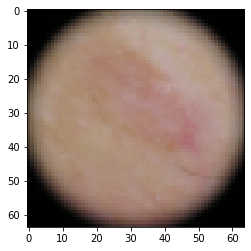

In [25]:
plt.imshow(testdata.iat[3, 7])
plt.show()

In [26]:
xtrain = np.array([i for i in traindata.loc[:, "image"].to_numpy().tolist()])
ytrain = traindata.loc[:, "target"].to_numpy()
xtest = np.array([i for i in testdata.loc[:, "image"].to_numpy().tolist()])
ytest = testdata.loc[:, "target"].to_numpy()
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(219678, 64, 64, 3)
(219678,)
(12098, 64, 64, 3)
(12098,)


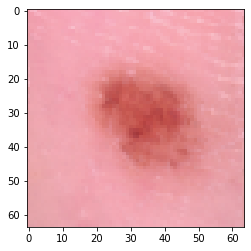

In [27]:
plt.imshow(xtrain[1])
plt.show()

In [28]:
xtrain.shape

(219678, 64, 64, 3)

In [29]:
xtrainloc = pd.get_dummies(traindata["anatom_site_general_challenge"])
xtestloc = pd.get_dummies(testdata["anatom_site_general_challenge"])

In [30]:
xtrainloc.loc[:, "torso"] = xtrainloc.loc[:, "torso"]|xtrainloc.loc[:, "lateral torso"]
xtestloc.loc[:, "torso"] = xtestloc.loc[:, "torso"]|xtestloc.loc[:, "lateral torso"]

In [31]:
xtrainloc = xtrainloc.drop("lateral torso", axis = 1)
xtestloc = xtestloc.drop("lateral torso", axis = 1)
gc.collect()

4966

In [32]:
xtrainsex = pd.get_dummies(traindata["sex"])
xtestsex = pd.get_dummies(testdata["sex"])

In [33]:
xtrainloc = xtrainloc.to_numpy()
xtestloc = xtestloc.to_numpy()
xtrainsex = xtrainsex.to_numpy()
xtestsex = xtestsex.to_numpy()

In [34]:
del traindata
del testdata
gc.collect()

60

In [35]:
results = pd.read_csv('../input/siim-isic-melanoma-classification/sample_submission.csv')
realtest = pd.read_csv("../input/siim-isic-melanoma-classification/test.csv")
X_testing = np.load("../input/siimisic-melanoma-resized-images/x_test_64.npy")

In [36]:
X_testing_loc = pd.get_dummies(realtest["anatom_site_general_challenge"])
X_testing_sex = pd.get_dummies(realtest["sex"])

In [37]:
X_testing_loc = X_testing_loc.to_numpy()
X_testing_sex = X_testing_sex.to_numpy()

In [38]:
xtrainloc

array([[0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [39]:
results

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0
...,...,...
10977,ISIC_9992485,0
10978,ISIC_9996992,0
10979,ISIC_9997917,0
10980,ISIC_9998234,0


In [40]:
# detect and init the TPU
#tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
# who knows what this does?
#BATCH_SIZE = 16 * tpu_strategy.num_replicas_in_sync
#print(BATCH_SIZE)

In [41]:
BATCH_SIZE = 2048 #* tpu_strategy.num_replicas_in_sync
print(BATCH_SIZE)
training_epochs = 3
#model_tests = 1

2048


In [42]:
gc.collect()

168

In [43]:
def makemodel(summarize = False, output_plot = False):
    imgin = tf.keras.layers.Input(shape = (64, 64, 3))
    imgmodel = tf.keras.layers.Lambda(lambda x: x / 255)(imgin)
    imgmodel = tf.keras.layers.Conv2D(32, kernel_size=(3, 3),activation='relu')(imgmodel)
    imgmodel = (tf.keras.layers.Conv2D(32, (3, 3), padding="valid"))(imgmodel)
    imgmodel = (tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))(imgmodel)
    imgmodel = (tf.keras.layers.Dropout(0.25))(imgmodel)
    imgmodel = (tf.keras.layers.Flatten())(imgmodel)
    imgmodel = (tf.keras.layers.Dense(256, activation='relu'))(imgmodel)
    imgmodel = (tf.keras.layers.Dropout(0.1))(imgmodel)
    imgmodel = (tf.keras.layers.Dense(256, activation='relu'))(imgmodel)
    imgmodel = (tf.keras.layers.Dropout(0.1))(imgmodel)
    imgmodel = (tf.keras.layers.Dense(256, activation='relu'))(imgmodel)
    imgmodel = (tf.keras.layers.Dropout(0.1))(imgmodel)
    imgmodel = (tf.keras.layers.Dense(256, activation='relu'))(imgmodel)
    #imgmodel.add(tf.keras.layers.Dropout(0.1))
    #imgmodel.add(tf.keras.layers.Dense(1, activation = "sigmoid"))


    lossfunc = tf.keras.losses.BinaryCrossentropy()
    #imgmodel.compile(loss = lossfunc,optimizer = 'Adam',metrics = ['accuracy'])

    auxin = tf.keras.layers.Input(shape = (6,))
    auxmodel = (tf.keras.layers.Dense(1, activation = "relu", input_shape = (6,)))(auxin)

    sexin = tf.keras.layers.Input(shape = (2,))
    sexmodel = (tf.keras.layers.Dense(1, activation = "relu", input_shape = (2,)))(sexin)

    concatlayer = tf.keras.layers.concatenate([imgmodel, auxmodel, sexmodel])
    outlayer = (tf.keras.layers.Dense(256, activation = "relu"))(concatlayer)
    outlayer = (tf.keras.layers.Dropout(0.2))(outlayer)
    outlayer = (tf.keras.layers.Dense(1, activation = "sigmoid"))(outlayer)

    model = tf.keras.Model(inputs = [imgin, auxin, sexin], outputs = outlayer)
    model.compile(loss = lossfunc, optimizer = "Adam", metrics=["accuracy", tf.keras.metrics.AUC()])
    if(summarize):
        model.summary()
    if(output_plot):
        tf.keras.utils.plot_model(model, to_file="model-visual-%s.png" % datetime.datetime.isoformat(datetime.datetime.now()), show_shapes=True)
    return model

In [44]:
#xtrain = np.float16(xtrain/255.0)
#xtest = np.float16(xtest/255.0)
#ytrain = np.float16(ytrain/255.0)
#ytest = np.float16(ytest/255.0)
#gc.collect()

In [45]:
#for i in range(model_tests):
model = makemodel(summarize = True)
gc.collect()
#    valrocscores.append([])
#    trainrocscores.append([])
for i in range(training_epochs):
    model.fit(x = [xtrain, xtrainloc, xtrainsex], y = ytrain, epochs = 1, validation_data = ([xtest, xtestloc, xtestsex], ytest), batch_size = BATCH_SIZE, validation_batch_size = BATCH_SIZE)
    gc.collect()
prediction = model.predict(x = [X_testing, X_testing_loc, X_testing_sex], batch_size = BATCH_SIZE)
results["target"] = prediction

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 64, 64, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 62, 32)   896         lambda[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 60, 60, 32)   9248        conv2d[0][0]                     
______________________________________________________________________________________________

In [46]:
#plt.figure(figsize=(20,20))
#plt.xlabel("epochs")
#plt.ylabel("validation roc")
#for i in valrocscores:
#    plt.plot(i)
#plt.savefig("rocscores-validation-%s.png" % datetime.datetime.isoformat(datetime.datetime.now()))

In [47]:
#plt.figure(figsize=(100,20))
#plt.xlabel("epochs")
#plt.ylabel("training roc")
#for i in trainrocscores:
#    plt.plot(i)
#plt.savefig("rocscores-training-%s.png" % datetime.datetime.isoformat(datetime.datetime.now()))

In [48]:
results.head()

,image_name,target
0,ISIC_0052060,0.029299
1,ISIC_0052349,0.000716
2,ISIC_0058510,0.000189
3,ISIC_0073313,0.000416
4,ISIC_0073502,0.034918


In [49]:
#finalresults = results.iloc[:, :2]

In [50]:
#resultsrank = results.copy()
#resultsrank.iloc[:, 2:] = resultsrank.iloc[:, 2:].rank(ascending = False)

In [51]:
#resultsrank

In [52]:
#finalresults.loc[:, "target"] = resultsrank.iloc[:, 2:].median(axis = 1)
#finalresults

In [53]:
#finalresults.loc[:, "target"] = 1/(np.float64(finalresults.loc[:, "target"]))

In [54]:
#print("%0.20f" % (finalresults.loc[0, "target"]))

In [55]:
results.to_csv("sample_cnn_%s.csv" % datetime.datetime.isoformat(datetime.datetime.now()), header=True, index=False)

In [56]:
#results.to_csv("raw_sample_cnn_%s.csv" % datetime.datetime.isoformat(datetime.datetime.now()), header=True, index=False)#

In [57]:
#model.save("trained_model %s.h5" % datetime.datetime.isoformat(datetime.datetime.now()))

In [58]:
gc.collect()

1015